**COMP551 Kaggle Competition Code Submission**
Amir Abushanb - 260624419, Vince Porporino - 260681922, Lili Zeng - 260429344

In [2]:
# IMPORTING LIBRARIES
##########################################################
%matplotlib inline
import numpy as np 
import scipy.misc # to visualize only  
import pandas as pd
import matplotlib.pyplot as plt
import string
import tensorflow as tf
print(tf.test.gpu_device_name())
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize, binarize
from sklearn.externals import joblib
from google.colab import auth
from google.colab import files
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, Input, Merge, concatenate
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, Adagrad
from math import exp
import warnings
import math
import random
import seaborn as sn
import itertools
warnings.filterwarnings("ignore")
##########################################################
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

/device:GPU:0


Using TensorFlow backend.


In [3]:
# IMPORTING DATA
##########################################################
auth.authenticate_user()
# Download the file.
!gsutil cp gs://ml_datasets/train_x.csv /tmp/train_x.csv
!gsutil cp gs://ml_datasets/train_y.csv /tmp/train_y.csv
!gsutil cp gs://ml_datasets/test_x.csv /tmp/test_x.csv

np_x_train = np.loadtxt('/tmp/train_x.csv', delimiter=",")
np_y_train = np.loadtxt('/tmp/train_y.csv', delimiter=",")
np_x_test = np.loadtxt('/tmp/test_x.csv', delimiter=",")

print("Files Successfully Loaded")
##########################################################

Copying gs://ml_datasets/train_x.csv...
| [1 files][  2.0 GiB/  2.0 GiB]   86.6 MiB/s                                   
Operation completed over 1 objects/2.0 GiB.                                      
Copying gs://ml_datasets/train_y.csv...
/ [1 files][ 97.7 KiB/ 97.7 KiB]                                                
Operation completed over 1 objects/97.7 KiB.                                     
Copying gs://ml_datasets/test_x.csv...
| [1 files][411.5 MiB/411.5 MiB]                                                
Operation completed over 1 objects/411.5 MiB.                                    
Files Successfully Loaded


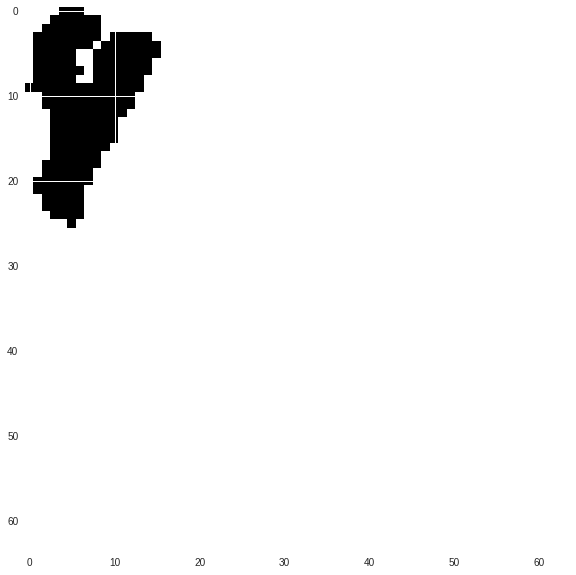

In [4]:
# DATA PREPROCESSING 
##########################################################
x = np_x_train
y = np_y_train
test = np_x_test
x = x.reshape(-1, 64, 64)
test = test.reshape(-1, 64, 64)
y = y.reshape(-1, 1) 
x = np.int64(x)
y = np.int64(y)
test = np.int64(x)

def preprocess(src_image):
    connectivity = 4
    offset = 0
    img = src_image.astype(np.uint8)
    ret,thresh = cv2.threshold(img,250,255,cv2.THRESH_BINARY)
    #ret is set to 250, it is the threshold number
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    n_components = output[0] - 1
    stats = output[2][1:]
    largest_component = np.array([])
    largest_area = 0
    largest_length = 0
    largest_height = 0
    for i in range(n_components):
        
        leftmost = stats[i][0]
        topmost = stats[i][1]
        length = stats[i][2]
        height = stats[i][3]
        #area = length * height #for rectangle bounding box
        area = max(length,height) ** 2 # for square bounding box
        if(area > largest_area):
            largest_area = area
            largest_length = length
            largest_height = height
            largest_component = thresh[topmost:height+topmost, leftmost:leftmost+length]
    
    result = np.zeros([64,64],dtype=np.uint8)
    result[offset:largest_height+offset,offset:largest_length+offset] = result[offset:largest_height+offset,offset:largest_length+offset] + largest_component
    
    return result

for i in range(x.shape[0]):
  x[i] = preprocess(x[i])

for j in range(test.shape[0]):
  test[j] = preprocess(test[j])


plt.imshow(x[0])
##########################################################

**Part 1: Standard Models**

In [11]:
# Standard Models
##########################################################

x_linear = x.reshape(50000, 4096)

X_train, X_test, y_train, y_test = train_test_split(x_linear, y,
                                                    train_size=0.75, test_size=0.25)

LSVC = LinearSVC().fit(X_train, y_train)
y_hat = LSVC.predict(X_test)
print("Linear SVC")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")

RF = RandomForestClassifier().fit(X_train, y_train)
y_hat = RF.predict(X_test)
print("Random Forest")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")

GB = GaussianNB().fit(X_train, y_train)
y_hat = GB.predict(X_test)
print("Gaussian NB")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")

MB = MultinomialNB().fit(X_train, y_train)
y_hat = MB.predict(X_test)
print("Multinomial NB")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")

SGD = SGDClassifier(max_iter=100).fit(X_train, y_train)
y_hat = SGD.predict(X_test)
print("SGD Classifier")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")

ada = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
y_hat = ada.predict(X_test)
print("ADA Boost")
print(confusion_matrix(y_test, y_hat))
print("Accuracy = ", accuracy_score(y_test, y_hat))
print("f1_score = ", f1_score(y_test, y_hat, average='micro'))
print("-------------------------------")
##########################################################

Linear SVC
[[ 128    5   83   34    9  106   57   79    5  741]
 [   2  818   18    0   44   30   34   27    4  393]
 [   5    5  507   22   21   79   39   61    5  448]
 [   5    5  225  155    8  107   10   50    2  687]
 [   1   20   64    5  129   26  101   13    8  905]
 [   8   11   46   32    9  385  129   22   12  520]
 [   9   13   86    7   19   59  616   15    9  382]
 [   2   13  140   22   22   46    8  453    2  574]
 [   0   14   63    9   18   81   23   21   18 1041]
 [   1    6   20    1   13   12    6   22    4 1121]]
Accuracy =  0.3464
f1_score =  0.3464
-------------------------------
Random Forest
[[1173    8    5   13    4    8   10    1   19    6]
 [  12 1250   14   11   10   12   14   18   16   13]
 [  21   12  963   32   50    5    7   38   44   20]
 [  24   19   63 1012   12   39    3   16   57    9]
 [  15   21   52   12 1027   11   28   20   13   73]
 [  28   13   16  100   21  861   69    9   44   13]
 [  24   17    8   14   25   52 1054   13    6    2]
 [ 

**Part 2: Nueral Net Implementation**

***IMPORTANT: THE NN WORKS JUST NOT IN THIS NOTEBOOK, I DON'T UNDERSTAND WHY EITHER, THE RUN TIME ALWAYS DIES, YET IT WORKS LOCALLY AND ON ALL OTHER NOTEBOOKS. PLEASE REFER TO THE OTHER NOTEBOOK IN THE SUBMISSION ( LINK: https://drive.google.com/file/d/1hHAeezk6vcba-wVKZqEcRiVCNo476FEg/view?usp=sharing ) IF YOU WOULD LIKE TO RUN IT***

In [0]:
# The good NN from scratch
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
  
def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def leaky_relu_derivative(x):
    x[x <= 0] = 0.01
    x[x > 0] = 1
    return x

# This function predicts the classes based on data 'x' and model 'model' 
def predict(model, x, activation):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Returns the class with highest probability
    return np.argmax(probabilities, axis=1)
  
# This function calculates the loss per datapoint based on data 'x', target 'y', and model 'model'
def calculate_loss(model, x, y, activation):
    nn_num_examples = x.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation 
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Calculating the loss (cross-entropy loss)
    corect_log_probs = -np.log(probabilities[range(nn_num_examples), y.astype(int)]) #this calculates: y_true*log(probabilities)
    data_loss = np.sum(corect_log_probs)
    return 1./nn_num_examples * data_loss
  
# This function fits a model to training data 'x_train' and target 'y_train'
# nn_hidden_dim: number of neurons in hidden layer
# nn_num_epoch: number of epochs
# nn_batch_size: number of datapoints in a batch used for batch stochastic gradient descent
# nn_step_size: step size of gradient descent
# nn_print_results: if true, prints after each epoch: loss on training set, accuracy on training set, accuracy on validation set
def fit_model(x_train, y_train, x_valid, y_valid, nn_hidden_dim, nn_num_epoch, nn_batch_size, nn_step_size, nn_print_results, activation='sigmoid'):
     
    nn_input_dim = x_train.shape[1]
    nn_output_dim = len(np.unique(y))
    nn_num_examples = x_train.shape[0]
    
    # Initialize the weights and the model
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden_dim)/np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden_dim))
    W2 = np.random.randn(nn_hidden_dim, nn_output_dim)/np.sqrt(nn_hidden_dim)
    b2 = np.zeros((1, nn_output_dim))
    model = {}
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
     
    # Gradient descent: for each epoch
    for i in range(nn_num_epoch):
      
        # For each batch
        for j in range(int(nn_num_examples/nn_batch_size)):
            x_batch = x_train[j*nn_batch_size:(j+1)*nn_batch_size]
            y_batch = y_train[j*nn_batch_size:(j+1)*nn_batch_size]
        
            # Forward propagation
            z1 = x_batch.dot(W1) + b1
            if activation == 'tanh':
              a1 = np.tanh(z1)
            elif activation == 'sigmoid':
              a1 = sigmoid(z1)
            elif activation == 'relu':
              a1 = np.maximum(z1,0)
            else:
              a1 = np.maximum(z1*0.01, z1)
            z2 = a1.dot(W2) + b2
            exp_result = np.exp(z2)
            probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True) #softmax
 
            # Backpropagation
            delta3 = probabilities
            delta3[range(nn_batch_size), y_batch.astype(int)] -= 1 #this calculates: probabilities - y_true 
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            if activation == 'tanh':
              delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            elif activation == 'sigmoid':
              delta2 = delta3.dot(W2.T) * a1*(1-a1)
            elif activation == 'relu':
              delta2 = delta3.dot(W2.T) * relu_derivative(z1)
            else:
              delta2 = delta3.dot(W2.T) * leaky_relu_derivative(z1)
              a1 = np.maximum(x*0.01, x)
            dW1 = np.dot(x_batch.T, delta2)
            db1 = np.sum(delta2, axis=0)
 
            # Parameter update
            W1 += -nn_step_size * dW1
            b1 += -nn_step_size * db1
            W2 += -nn_step_size * dW2
            b2 += -nn_step_size * db2
         
        # Output model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Print results for each epoch
        if nn_print_results:
            t_loss = calculate_loss(model, x_train, y_train, activation)
            print('Training loss after epoch ', i, ': ', t_loss)
            train_loss.append(t_loss)
            y_train_pred = predict(model, x_train, activation)
            t_acc = accuracy_score(y_train, y_train_pred)
            print('Training accuracy: ', t_acc)
            train_accuracy.append(t_acc)
            v_loss = calculate_loss(model, x_valid, y_valid, activation)
            print('Validation Loss after epoch ', i, ': ', v_loss)
            valid_loss.append(v_loss)
            y_valid_pred = predict(model, x_valid, activation)
            v_acc = accuracy_score(y_valid, y_valid_pred)
            print('Validation accuracy: ', v_acc)
            valid_accuracy.append(v_acc)
     
    return model, train_loss, valid_loss, train_accuracy, valid_accuracy

nn_batch_size = [100, 200]
nn_hidden_layer = [5, 10, 50]
nn_stepsize = [0.01, 0.001]
nn_activations = ['sigmoid', 'tanh']
nn_epoch = 20

x_linear = x.reshape(50000, 4096)

X_train, X_test, y_train, y_test = train_test_split(x_linear, y,
                                                    train_size=0.75, test_size=0.25, shuffle = True)

for l in nn_activations:
  for i in nn_batch_size:
    for j in nn_hidden_layer:
      for k in nn_stepsize:
        print('Activation Func: ', l, ' Batch size: ', i, ' Neurons in hidden layer: ', j, ' Step size: ', k)

        model = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=j, nn_num_epoch=nn_epoch, nn_batch_size=i, nn_step_size=k, nn_print_results=True, activation = l)
      
        print(' ')
  print('-----------------------------------------------')
  
model, train_loss, valid_loss, train_accuracy, valid_accuracy = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=50, nn_num_epoch=20, nn_batch_size=200, nn_step_size=0.001, nn_print_results=True, activation = 'sigmoid')

epoch = [i for i in range(20)]

plt.plot(epoch, train_loss)
plt.plot(epoch, valid_loss)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Loss per data point")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Activation Func:  sigmoid  Batch size:  100  Neurons in hidden layer:  5  Step size:  0.01


**Part 3: CNNs**

In [0]:
# Helper code, don't forget to run
class Model_Accuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

45000/45000 [==============================] - 27s 594us/step - loss: 0.9104 - acc: 0.7103 - val_loss: 0.4108 - val_acc: 0.8836
Epoch 2/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.4367 - acc: 0.8761 - val_loss: 0.3151 - val_acc: 0.9154
Epoch 3/60
35584/45000 [======================>.......] - ETA: 4s - loss: 0.3572 - acc: 0.8989

45000/45000 [==============================] - 25s 548us/step - loss: 0.3523 - acc: 0.9000 - val_loss: 0.2826 - val_acc: 0.9238
Epoch 4/60
45000/45000 [==============================] - 25s 548us/step - loss: 0.3052 - acc: 0.9146 - val_loss: 0.2647 - val_acc: 0.9326
Epoch 5/60
40704/45000 [==========================>...] - ETA: 2s - loss: 0.2770 - acc: 0.9233

45000/45000 [==============================] - 25s 548us/step - loss: 0.2772 - acc: 0.9232 - val_loss: 0.2575 - val_acc: 0.9350
Epoch 6/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.2540 - acc: 0.9305 - val_loss: 0.2495 - val_acc: 0.9396
Epoch 7/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.2375 - acc: 0.9340

45000/45000 [==============================] - 25s 547us/step - loss: 0.2389 - acc: 0.9340 - val_loss: 0.2457 - val_acc: 0.9382
Epoch 8/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.2237 - acc: 0.9381 - val_loss: 0.2540 - val_acc: 0.9382
Epoch 9/60
41984/45000 [==========================>...] - ETA: 1s - loss: 0.2100 - acc: 0.9415

45000/45000 [==============================] - 25s 548us/step - loss: 0.2094 - acc: 0.9416 - val_loss: 0.2449 - val_acc: 0.9412
Epoch 10/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.1984 - acc: 0.9439 - val_loss: 0.2356 - val_acc: 0.9422
Epoch 11/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1884 - acc: 0.9469

45000/45000 [==============================] - 25s 545us/step - loss: 0.1895 - acc: 0.9469 - val_loss: 0.2385 - val_acc: 0.9440
Epoch 12/60
45000/45000 [==============================] - 25s 548us/step - loss: 0.1848 - acc: 0.9483 - val_loss: 0.2322 - val_acc: 0.9448
Epoch 13/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1726 - acc: 0.9496

45000/45000 [==============================] - 25s 547us/step - loss: 0.1732 - acc: 0.9497 - val_loss: 0.2481 - val_acc: 0.9432
Epoch 14/60
45000/45000 [==============================] - 25s 548us/step - loss: 0.1698 - acc: 0.9518 - val_loss: 0.2437 - val_acc: 0.9456
Epoch 15/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1646 - acc: 0.9518

45000/45000 [==============================] - 25s 548us/step - loss: 0.1642 - acc: 0.9522 - val_loss: 0.2427 - val_acc: 0.9432
Epoch 16/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.1573 - acc: 0.9539 - val_loss: 0.2389 - val_acc: 0.9460
Epoch 17/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1523 - acc: 0.9562

45000/45000 [==============================] - 25s 548us/step - loss: 0.1515 - acc: 0.9561 - val_loss: 0.2519 - val_acc: 0.9478
Epoch 18/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.1486 - acc: 0.9563 - val_loss: 0.2489 - val_acc: 0.9458
Epoch 19/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1380 - acc: 0.9594

45000/45000 [==============================] - 25s 546us/step - loss: 0.1388 - acc: 0.9592 - val_loss: 0.2667 - val_acc: 0.9450
Epoch 20/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.1371 - acc: 0.9583 - val_loss: 0.2591 - val_acc: 0.9466
Epoch 21/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1324 - acc: 0.9597

45000/45000 [==============================] - 25s 547us/step - loss: 0.1332 - acc: 0.9596 - val_loss: 0.2554 - val_acc: 0.9482
Epoch 22/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.1302 - acc: 0.9604 - val_loss: 0.2625 - val_acc: 0.9466
Epoch 23/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1274 - acc: 0.9609

45000/45000 [==============================] - 25s 546us/step - loss: 0.1277 - acc: 0.9609 - val_loss: 0.2688 - val_acc: 0.9462
Epoch 24/60
45000/45000 [==============================] - 25s 548us/step - loss: 0.1220 - acc: 0.9633 - val_loss: 0.2711 - val_acc: 0.9462
Epoch 25/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1182 - acc: 0.9636

45000/45000 [==============================] - 25s 547us/step - loss: 0.1176 - acc: 0.9639 - val_loss: 0.2767 - val_acc: 0.9472
Epoch 26/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.1186 - acc: 0.9628 - val_loss: 0.2657 - val_acc: 0.9482
Epoch 27/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1121 - acc: 0.9653

45000/45000 [==============================] - 25s 547us/step - loss: 0.1132 - acc: 0.9650 - val_loss: 0.2852 - val_acc: 0.9474
Epoch 28/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.1116 - acc: 0.9651 - val_loss: 0.2848 - val_acc: 0.9484
Epoch 29/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1090 - acc: 0.9657

45000/45000 [==============================] - 25s 547us/step - loss: 0.1098 - acc: 0.9654 - val_loss: 0.2825 - val_acc: 0.9478
Epoch 30/60
45000/45000 [==============================] - 25s 549us/step - loss: 0.1088 - acc: 0.9656 - val_loss: 0.2948 - val_acc: 0.9456
Epoch 31/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1015 - acc: 0.9676

45000/45000 [==============================] - 25s 547us/step - loss: 0.1024 - acc: 0.9673 - val_loss: 0.2784 - val_acc: 0.9474
Epoch 32/60
45000/45000 [==============================] - 25s 547us/step - loss: 0.1058 - acc: 0.9667 - val_loss: 0.2947 - val_acc: 0.9452
Epoch 33/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1008 - acc: 0.9680

45000/45000 [==============================] - 25s 546us/step - loss: 0.1016 - acc: 0.9676 - val_loss: 0.2898 - val_acc: 0.9472
Epoch 34/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.0981 - acc: 0.9671 - val_loss: 0.2931 - val_acc: 0.9468
Epoch 35/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0942 - acc: 0.9687

45000/45000 [==============================] - 25s 546us/step - loss: 0.0939 - acc: 0.9690 - val_loss: 0.2969 - val_acc: 0.9472
Epoch 36/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.0961 - acc: 0.9685 - val_loss: 0.2917 - val_acc: 0.9488
Epoch 37/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0962 - acc: 0.9690

45000/45000 [==============================] - 25s 547us/step - loss: 0.0963 - acc: 0.9688 - val_loss: 0.3023 - val_acc: 0.9444
Epoch 38/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0915 - acc: 0.9701 - val_loss: 0.3021 - val_acc: 0.9462
Epoch 39/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0907 - acc: 0.9704

45000/45000 [==============================] - 25s 545us/step - loss: 0.0909 - acc: 0.9704 - val_loss: 0.3138 - val_acc: 0.9446
Epoch 40/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.0875 - acc: 0.9711 - val_loss: 0.3155 - val_acc: 0.9448
Epoch 41/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0874 - acc: 0.9713

45000/45000 [==============================] - 25s 546us/step - loss: 0.0879 - acc: 0.9709 - val_loss: 0.3068 - val_acc: 0.9468
Epoch 42/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0872 - acc: 0.9714 - val_loss: 0.3101 - val_acc: 0.9482
Epoch 43/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0864 - acc: 0.9717

45000/45000 [==============================] - 25s 545us/step - loss: 0.0864 - acc: 0.9716 - val_loss: 0.3172 - val_acc: 0.9486
Epoch 44/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0822 - acc: 0.9729 - val_loss: 0.3275 - val_acc: 0.9474
Epoch 45/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0777 - acc: 0.9746

45000/45000 [==============================] - 25s 546us/step - loss: 0.0775 - acc: 0.9744 - val_loss: 0.3270 - val_acc: 0.9456
Epoch 46/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0803 - acc: 0.9730 - val_loss: 0.3185 - val_acc: 0.9462
Epoch 47/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0779 - acc: 0.9738

45000/45000 [==============================] - 25s 545us/step - loss: 0.0780 - acc: 0.9738 - val_loss: 0.3228 - val_acc: 0.9482
Epoch 48/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.0762 - acc: 0.9744 - val_loss: 0.3170 - val_acc: 0.9464
Epoch 49/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0793 - acc: 0.9737

45000/45000 [==============================] - 25s 546us/step - loss: 0.0791 - acc: 0.9737 - val_loss: 0.3231 - val_acc: 0.9454
Epoch 50/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0782 - acc: 0.9740 - val_loss: 0.3311 - val_acc: 0.9470
Epoch 51/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0788 - acc: 0.9732

45000/45000 [==============================] - 24s 544us/step - loss: 0.0786 - acc: 0.9733 - val_loss: 0.3274 - val_acc: 0.9480
Epoch 52/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0758 - acc: 0.9738 - val_loss: 0.3216 - val_acc: 0.9478
Epoch 53/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0682 - acc: 0.9765

45000/45000 [==============================] - 25s 546us/step - loss: 0.0689 - acc: 0.9762 - val_loss: 0.3371 - val_acc: 0.9478
Epoch 54/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0712 - acc: 0.9768 - val_loss: 0.3330 - val_acc: 0.9484
Epoch 55/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0726 - acc: 0.9759

45000/45000 [==============================] - 25s 545us/step - loss: 0.0716 - acc: 0.9763 - val_loss: 0.3593 - val_acc: 0.9468
Epoch 56/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0716 - acc: 0.9766 - val_loss: 0.3322 - val_acc: 0.9458
Epoch 57/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0708 - acc: 0.9758

45000/45000 [==============================] - 25s 546us/step - loss: 0.0710 - acc: 0.9754 - val_loss: 0.3494 - val_acc: 0.9468
Epoch 58/60
45000/45000 [==============================] - 25s 545us/step - loss: 0.0658 - acc: 0.9776 - val_loss: 0.3411 - val_acc: 0.9464
Epoch 59/60
41728/45000 [==========================>...] - ETA: 1s - loss: 0.0704 - acc: 0.9768

45000/45000 [==============================] - 25s 545us/step - loss: 0.0702 - acc: 0.9766 - val_loss: 0.3453 - val_acc: 0.9480
Epoch 60/60
45000/45000 [==============================] - 25s 546us/step - loss: 0.0684 - acc: 0.9766 - val_loss: 0.3442 - val_acc: 0.9450
Test loss: 0.34417701893355696
Test accuracy: 0.945


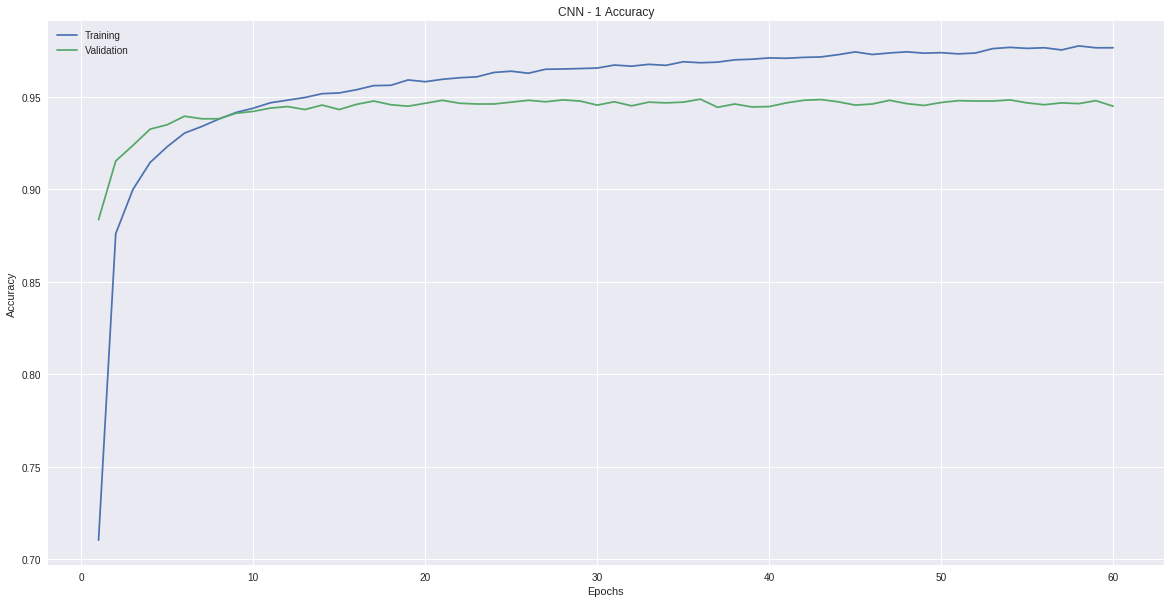

In [6]:
# CNNs
##########################################################
        

# Model 1 (Best Model):
num_classes = 10
batch_size = 256
epochs = 60

img_dim = 64

x_train, x_test, y_train, y_test = train_test_split(x, y,
    train_size=0.9, test_size=0.1, shuffle=True)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, 1)
input_shape = (img_dim, img_dim, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
BatchNormalization()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
BatchNormalization()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

history = Model_Accuracy()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam', #'adadelta'
              metrics=['accuracy'])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history.acc)
plt.plot(range(1, epochs +1), history.val_acc)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 1 Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

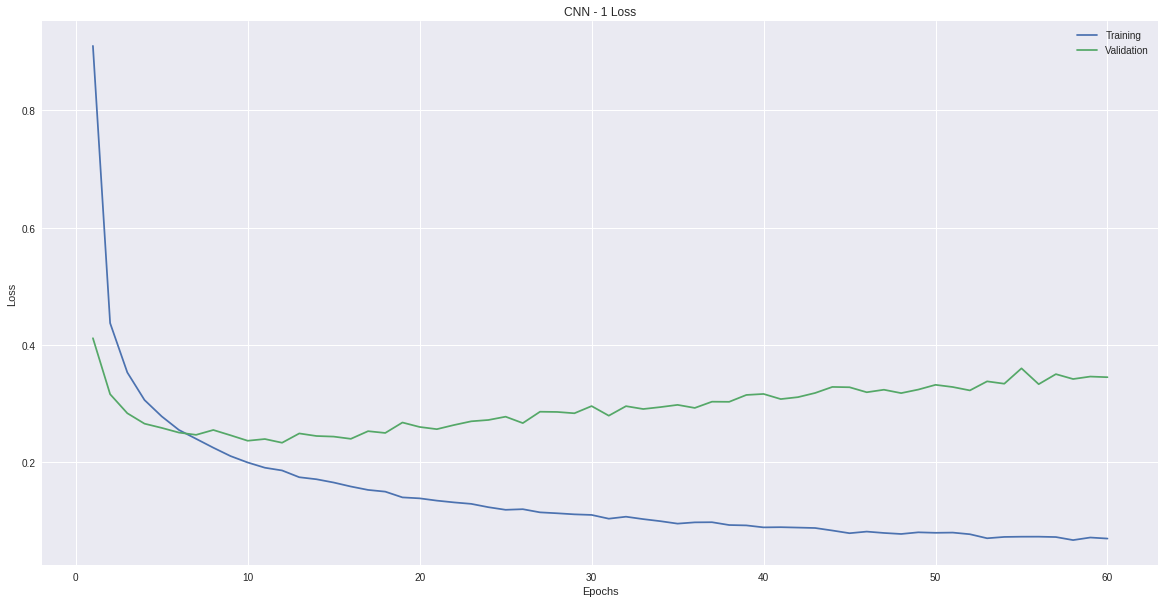

In [7]:
plt.plot(range(1, epochs + 1), history.loss)
plt.plot(range(1, epochs +1), history.val_loss)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 1 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 64)        0         
__________

703/703 [==============================] - 78s 111ms/step - loss: 0.8480 - acc: 0.7290 - val_loss: 0.3185 - val_acc: 0.9133
Epoch 2/20
208/703 [=======>......................] - ETA: 50s - loss: 0.4944 - acc: 0.8510

703/703 [==============================] - 77s 110ms/step - loss: 0.4553 - acc: 0.8656 - val_loss: 0.2759 - val_acc: 0.9287
Epoch 3/20
270/703 [==========>...................] - ETA: 44s - loss: 0.3994 - acc: 0.8848

703/703 [==============================] - 78s 110ms/step - loss: 0.3882 - acc: 0.8895 - val_loss: 0.2482 - val_acc: 0.9332
Epoch 4/20
300/703 [===========>..................] - ETA: 41s - loss: 0.3672 - acc: 0.8965

703/703 [==============================] - 77s 110ms/step - loss: 0.3607 - acc: 0.8989 - val_loss: 0.2318 - val_acc: 0.9407
Epoch 5/20
307/703 [============>.................] - ETA: 40s - loss: 0.3382 - acc: 0.9031

703/703 [==============================] - 77s 110ms/step - loss: 0.3355 - acc: 0.9049 - val_loss: 0.2475 - val_acc: 0.9392
Epoch 6/20
310/703 [============>.................] - ETA: 41s - loss: 0.3219 - acc: 0.9104

703/703 [==============================] - 78s 111ms/step - loss: 0.3184 - acc: 0.9111 - val_loss: 0.2147 - val_acc: 0.9436
Epoch 7/20
307/703 [============>.................] - ETA: 40s - loss: 0.3173 - acc: 0.9114

703/703 [==============================] - 77s 109ms/step - loss: 0.3102 - acc: 0.9136 - val_loss: 0.2341 - val_acc: 0.9402
Epoch 8/20
305/703 [============>.................] - ETA: 40s - loss: 0.2997 - acc: 0.9181

703/703 [==============================] - 77s 109ms/step - loss: 0.2982 - acc: 0.9178 - val_loss: 0.2305 - val_acc: 0.9423
Epoch 9/20
305/703 [============>.................] - ETA: 40s - loss: 0.2960 - acc: 0.9199

703/703 [==============================] - 77s 110ms/step - loss: 0.2900 - acc: 0.9203 - val_loss: 0.2163 - val_acc: 0.9464
Epoch 10/20
308/703 [============>.................] - ETA: 40s - loss: 0.2861 - acc: 0.9193

703/703 [==============================] - 77s 109ms/step - loss: 0.2797 - acc: 0.9216 - val_loss: 0.2146 - val_acc: 0.9477
Epoch 11/20
308/703 [============>.................] - ETA: 41s - loss: 0.2786 - acc: 0.9222

703/703 [==============================] - 78s 111ms/step - loss: 0.2756 - acc: 0.9232 - val_loss: 0.2189 - val_acc: 0.9473
Epoch 12/20
310/703 [============>.................] - ETA: 39s - loss: 0.2686 - acc: 0.9251

703/703 [==============================] - 77s 109ms/step - loss: 0.2669 - acc: 0.9265 - val_loss: 0.2154 - val_acc: 0.9482
Epoch 13/20
309/703 [============>.................] - ETA: 40s - loss: 0.2642 - acc: 0.9266

703/703 [==============================] - 77s 110ms/step - loss: 0.2604 - acc: 0.9276 - val_loss: 0.2133 - val_acc: 0.9504
Epoch 14/20
308/703 [============>.................] - ETA: 40s - loss: 0.2624 - acc: 0.9268

703/703 [==============================] - 77s 109ms/step - loss: 0.2580 - acc: 0.9283 - val_loss: 0.2152 - val_acc: 0.9484
Epoch 15/20
306/703 [============>.................] - ETA: 40s - loss: 0.2531 - acc: 0.9299

703/703 [==============================] - 77s 109ms/step - loss: 0.2548 - acc: 0.9299 - val_loss: 0.2193 - val_acc: 0.9459
Epoch 16/20
308/703 [============>.................] - ETA: 41s - loss: 0.2495 - acc: 0.9305

703/703 [==============================] - 78s 111ms/step - loss: 0.2471 - acc: 0.9316 - val_loss: 0.2112 - val_acc: 0.9503
Epoch 17/20
308/703 [============>.................] - ETA: 40s - loss: 0.2407 - acc: 0.9339

703/703 [==============================] - 77s 110ms/step - loss: 0.2430 - acc: 0.9333 - val_loss: 0.2005 - val_acc: 0.9523
Epoch 18/20
307/703 [============>.................] - ETA: 40s - loss: 0.2417 - acc: 0.9327

703/703 [==============================] - 77s 110ms/step - loss: 0.2386 - acc: 0.9339 - val_loss: 0.2006 - val_acc: 0.9504
Epoch 19/20
309/703 [============>.................] - ETA: 40s - loss: 0.2365 - acc: 0.9354

703/703 [==============================] - 77s 109ms/step - loss: 0.2343 - acc: 0.9352 - val_loss: 0.2023 - val_acc: 0.9519
Epoch 20/20
310/703 [============>.................] - ETA: 40s - loss: 0.2330 - acc: 0.9369

703/703 [==============================] - 77s 110ms/step - loss: 0.2315 - acc: 0.9366 - val_loss: 0.2074 - val_acc: 0.9513
Test loss: 0.20674980012893676
Test accuracy: 0.9506399999809265


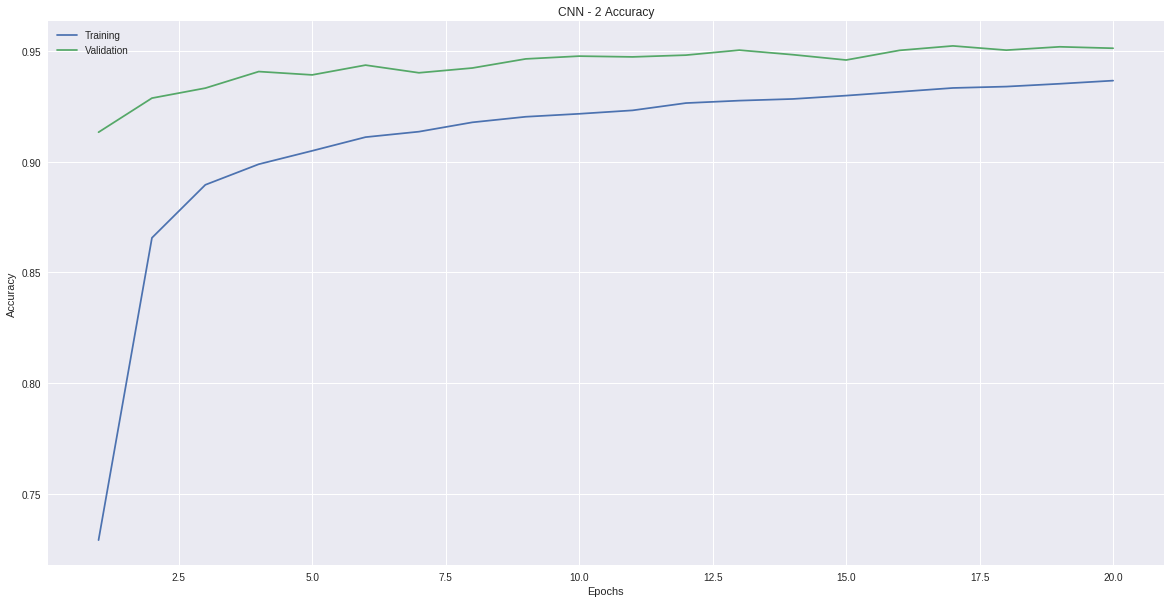

In [8]:
# Model 2: Used an image generator and a slightly different architecture and a
# different train-test split

batch_size = 512
epochs = 20

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))
history2 = Model_Accuracy()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=128)
test_generator = test_gen.flow(x_test, y_test, batch_size=128)

model.fit_generator(train_generator, steps_per_epoch=45000//64, epochs=epochs, callbacks=[history2],
                    validation_data=test_generator, validation_steps=10000//64)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history2.acc)
plt.plot(range(1, epochs +1), history2.val_acc)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 2 Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

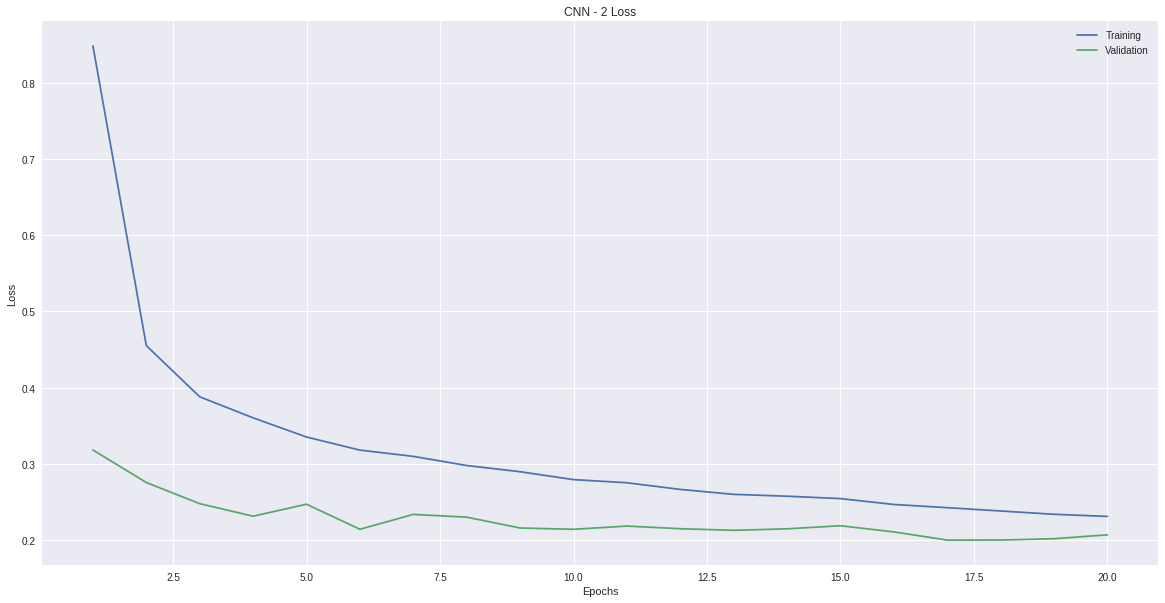

In [9]:
plt.plot(range(1, epochs + 1), history2.loss)
plt.plot(range(1, epochs +1), history2.val_loss)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 2 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       12928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
__________

147/147 [==============================] - 24s 160ms/step - loss: 1.4698 - acc: 0.4848 - val_loss: 0.6745 - val_acc: 0.7989
Epoch 2/50
147/147 [==============================] - 22s 150ms/step - loss: 0.7001 - acc: 0.7835 - val_loss: 0.4634 - val_acc: 0.8644
Epoch 3/50
147/147 [==============================] - 23s 155ms/step - loss: 0.5570 - acc: 0.8343 - val_loss: 0.4069 - val_acc: 0.8822
Epoch 4/50
 23/147 [===>..........................] - ETA: 16s - loss: 0.4867 - acc: 0.8617

147/147 [==============================] - 22s 151ms/step - loss: 0.4757 - acc: 0.8642 - val_loss: 0.3481 - val_acc: 0.9028
Epoch 5/50
147/147 [==============================] - 23s 154ms/step - loss: 0.4375 - acc: 0.8752 - val_loss: 0.3268 - val_acc: 0.9086
Epoch 6/50
147/147 [==============================] - 22s 151ms/step - loss: 0.4034 - acc: 0.8860 - val_loss: 0.3094 - val_acc: 0.9146
Epoch 7/50
 15/147 [==>...........................] - ETA: 16s - loss: 0.3848 - acc: 0.8952

147/147 [==============================] - 23s 154ms/step - loss: 0.3846 - acc: 0.8945 - val_loss: 0.3087 - val_acc: 0.9165
Epoch 8/50
147/147 [==============================] - 22s 150ms/step - loss: 0.3658 - acc: 0.8984 - val_loss: 0.2915 - val_acc: 0.9210
Epoch 9/50
147/147 [==============================] - 23s 153ms/step - loss: 0.3501 - acc: 0.9027 - val_loss: 0.2693 - val_acc: 0.9266
Epoch 10/50
 14/147 [=>............................] - ETA: 16s - loss: 0.3366 - acc: 0.9009

147/147 [==============================] - 22s 151ms/step - loss: 0.3375 - acc: 0.9059 - val_loss: 0.2783 - val_acc: 0.9292
Epoch 11/50
147/147 [==============================] - 22s 153ms/step - loss: 0.3350 - acc: 0.9082 - val_loss: 0.2819 - val_acc: 0.9242
Epoch 12/50
147/147 [==============================] - 22s 151ms/step - loss: 0.3205 - acc: 0.9116 - val_loss: 0.2668 - val_acc: 0.9295
Epoch 13/50
 14/147 [=>............................] - ETA: 16s - loss: 0.3102 - acc: 0.9124

147/147 [==============================] - 22s 151ms/step - loss: 0.3084 - acc: 0.9157 - val_loss: 0.2537 - val_acc: 0.9309
Epoch 14/50
147/147 [==============================] - 22s 151ms/step - loss: 0.3015 - acc: 0.9189 - val_loss: 0.2616 - val_acc: 0.9305
Epoch 15/50
147/147 [==============================] - 22s 151ms/step - loss: 0.3016 - acc: 0.9178 - val_loss: 0.2572 - val_acc: 0.9317
Epoch 16/50
 13/147 [=>............................] - ETA: 16s - loss: 0.2981 - acc: 0.9180

147/147 [==============================] - 23s 157ms/step - loss: 0.2964 - acc: 0.9186 - val_loss: 0.2540 - val_acc: 0.9333
Epoch 17/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2873 - acc: 0.9225 - val_loss: 0.2789 - val_acc: 0.9250
Epoch 18/50
147/147 [==============================] - 23s 156ms/step - loss: 0.2887 - acc: 0.9224 - val_loss: 0.2531 - val_acc: 0.9303
Epoch 19/50
 12/147 [=>............................] - ETA: 16s - loss: 0.2635 - acc: 0.9274

147/147 [==============================] - 22s 151ms/step - loss: 0.2745 - acc: 0.9256 - val_loss: 0.2508 - val_acc: 0.9331
Epoch 20/50
147/147 [==============================] - 23s 155ms/step - loss: 0.2755 - acc: 0.9247 - val_loss: 0.2404 - val_acc: 0.9359
Epoch 21/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2636 - acc: 0.9291 - val_loss: 0.2376 - val_acc: 0.9369
Epoch 22/50
 13/147 [=>............................] - ETA: 16s - loss: 0.2476 - acc: 0.9324

147/147 [==============================] - 23s 156ms/step - loss: 0.2676 - acc: 0.9276 - val_loss: 0.2389 - val_acc: 0.9365
Epoch 23/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2677 - acc: 0.9262 - val_loss: 0.2334 - val_acc: 0.9366
Epoch 24/50
147/147 [==============================] - 23s 155ms/step - loss: 0.2575 - acc: 0.9304 - val_loss: 0.2467 - val_acc: 0.9352
Epoch 25/50
 14/147 [=>............................] - ETA: 15s - loss: 0.2497 - acc: 0.9266

147/147 [==============================] - 22s 150ms/step - loss: 0.2578 - acc: 0.9291 - val_loss: 0.2449 - val_acc: 0.9351
Epoch 26/50
147/147 [==============================] - 23s 154ms/step - loss: 0.2517 - acc: 0.9324 - val_loss: 0.2414 - val_acc: 0.9367
Epoch 27/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2469 - acc: 0.9334 - val_loss: 0.2406 - val_acc: 0.9385
Epoch 28/50
 12/147 [=>............................] - ETA: 15s - loss: 0.2289 - acc: 0.9408

147/147 [==============================] - 23s 154ms/step - loss: 0.2438 - acc: 0.9333 - val_loss: 0.2427 - val_acc: 0.9382
Epoch 29/50
147/147 [==============================] - 22s 150ms/step - loss: 0.2398 - acc: 0.9337 - val_loss: 0.2354 - val_acc: 0.9392
Epoch 30/50
147/147 [==============================] - 22s 153ms/step - loss: 0.2411 - acc: 0.9348 - val_loss: 0.2355 - val_acc: 0.9386
Epoch 31/50
 14/147 [=>............................] - ETA: 15s - loss: 0.2295 - acc: 0.9369

147/147 [==============================] - 22s 150ms/step - loss: 0.2438 - acc: 0.9332 - val_loss: 0.2410 - val_acc: 0.9372
Epoch 32/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2433 - acc: 0.9340 - val_loss: 0.2479 - val_acc: 0.9375
Epoch 33/50
147/147 [==============================] - 23s 156ms/step - loss: 0.2293 - acc: 0.9377 - val_loss: 0.2372 - val_acc: 0.9391
Epoch 34/50
 11/147 [=>............................] - ETA: 15s - loss: 0.2219 - acc: 0.9411

147/147 [==============================] - 22s 150ms/step - loss: 0.2264 - acc: 0.9391 - val_loss: 0.2316 - val_acc: 0.9408
Epoch 35/50
147/147 [==============================] - 23s 156ms/step - loss: 0.2279 - acc: 0.9377 - val_loss: 0.2494 - val_acc: 0.9355
Epoch 36/50
147/147 [==============================] - 22s 150ms/step - loss: 0.2244 - acc: 0.9388 - val_loss: 0.2366 - val_acc: 0.9410
Epoch 37/50
 11/147 [=>............................] - ETA: 16s - loss: 0.2183 - acc: 0.9439

147/147 [==============================] - 23s 157ms/step - loss: 0.2195 - acc: 0.9412 - val_loss: 0.2403 - val_acc: 0.9388
Epoch 38/50
147/147 [==============================] - 22s 150ms/step - loss: 0.2227 - acc: 0.9394 - val_loss: 0.2322 - val_acc: 0.9397
Epoch 39/50
147/147 [==============================] - 23s 156ms/step - loss: 0.2185 - acc: 0.9408 - val_loss: 0.2494 - val_acc: 0.9393
Epoch 40/50
 12/147 [=>............................] - ETA: 15s - loss: 0.2068 - acc: 0.9440

147/147 [==============================] - 22s 150ms/step - loss: 0.2180 - acc: 0.9423 - val_loss: 0.2357 - val_acc: 0.9403
Epoch 41/50
147/147 [==============================] - 23s 156ms/step - loss: 0.2203 - acc: 0.9412 - val_loss: 0.2329 - val_acc: 0.9410
Epoch 42/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2157 - acc: 0.9425 - val_loss: 0.2382 - val_acc: 0.9413
Epoch 43/50
 13/147 [=>............................] - ETA: 16s - loss: 0.2183 - acc: 0.9414

147/147 [==============================] - 23s 155ms/step - loss: 0.2166 - acc: 0.9412 - val_loss: 0.2353 - val_acc: 0.9402
Epoch 44/50
147/147 [==============================] - 22s 150ms/step - loss: 0.2128 - acc: 0.9413 - val_loss: 0.2432 - val_acc: 0.9384
Epoch 45/50
147/147 [==============================] - 23s 154ms/step - loss: 0.2100 - acc: 0.9422 - val_loss: 0.2520 - val_acc: 0.9371
Epoch 46/50
 14/147 [=>............................] - ETA: 15s - loss: 0.2039 - acc: 0.9403

147/147 [==============================] - 22s 150ms/step - loss: 0.2084 - acc: 0.9436 - val_loss: 0.2355 - val_acc: 0.9424
Epoch 47/50
147/147 [==============================] - 23s 154ms/step - loss: 0.2081 - acc: 0.9432 - val_loss: 0.2473 - val_acc: 0.9397
Epoch 48/50
147/147 [==============================] - 22s 151ms/step - loss: 0.2105 - acc: 0.9423 - val_loss: 0.2464 - val_acc: 0.9389
Epoch 49/50
 13/147 [=>............................] - ETA: 16s - loss: 0.1961 - acc: 0.9480

147/147 [==============================] - 23s 154ms/step - loss: 0.2091 - acc: 0.9446 - val_loss: 0.2448 - val_acc: 0.9386
Epoch 50/50
147/147 [==============================] - 22s 150ms/step - loss: 0.2018 - acc: 0.9455 - val_loss: 0.2479 - val_acc: 0.9409
Test loss: 0.247911856443882
Test accuracy: 0.940879999961853


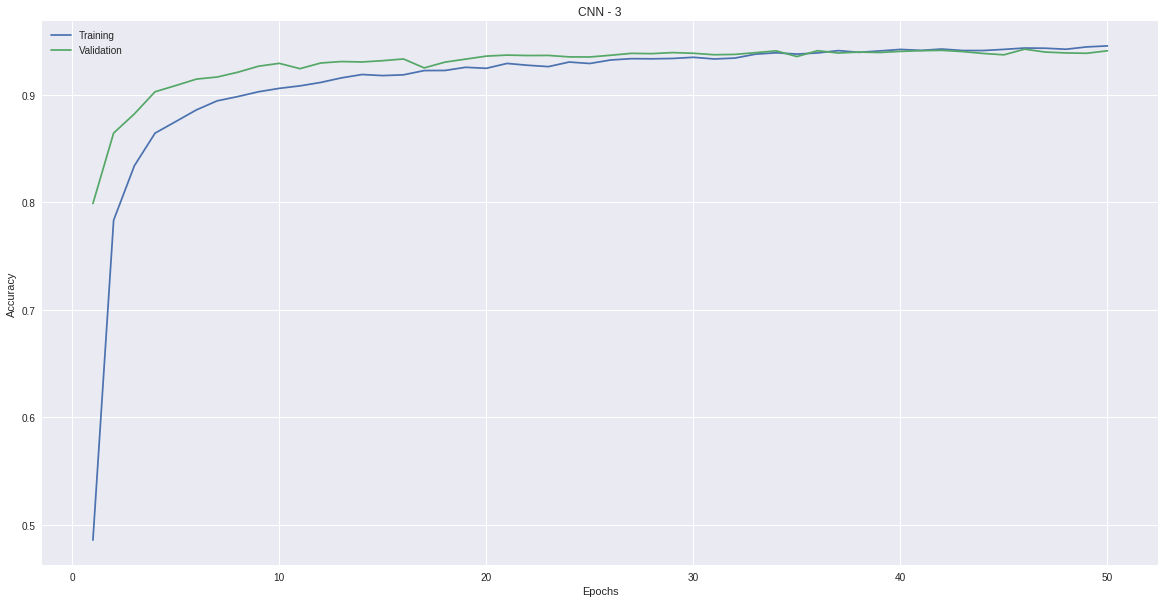

In [8]:
# Model 3
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True)
img_dim = 64
num_classes = 10
input_shape = (img_dim, img_dim, 1)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

batch_size = 256
epochs = 50

model = Sequential()
model.add(Conv2D(128, kernel_size=(10, 10), strides=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(8, 8), strides=(4, 4)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(num_classes, activation='softmax'))

history3 = Model_Accuracy()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

gen = ImageDataGenerator(rotation_range=2, width_shift_range=0.02, shear_range=0.1,
                         height_shift_range=0.02, zoom_range=0.02)

test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_gen.flow(x_test, y_test, batch_size=batch_size)

model.fit_generator(train_generator, epochs=epochs, 
                    validation_data=test_generator, verbose=1, callbacks=[history3])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history3.acc)
plt.plot(range(1, epochs +1), history3.val_acc)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 3")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

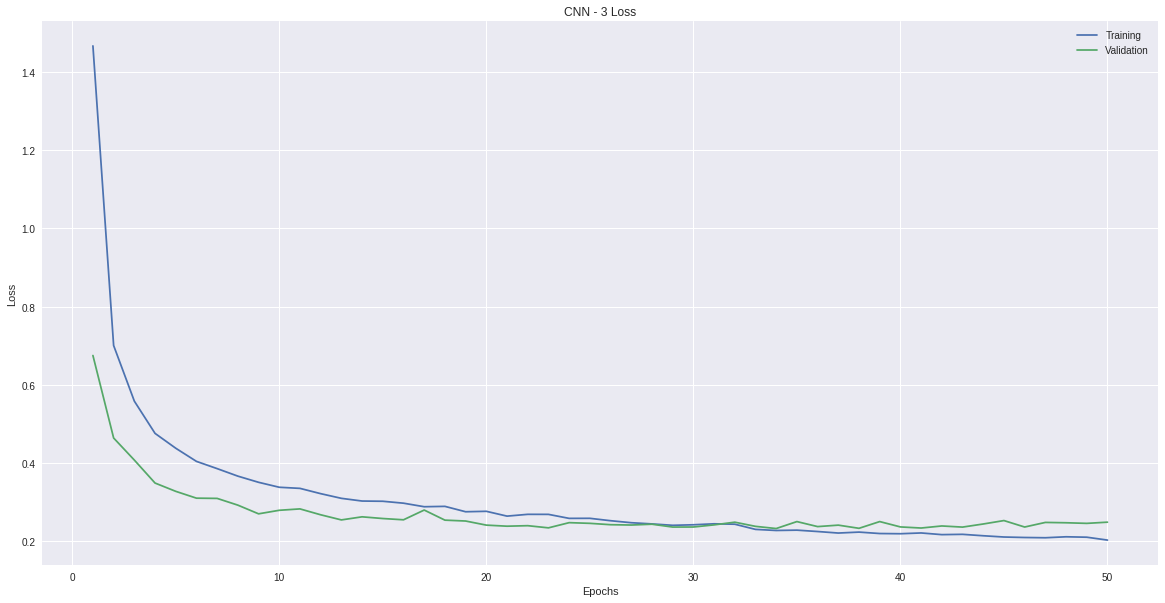

In [9]:
plt.plot(range(1, epochs + 1), history3.loss)
plt.plot(range(1, epochs +1), history3.val_loss)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 3 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Confusion matrix, without normalization
[[1249    0    0    5    0    3    3    0    3    1]
 [  15 1280   14    9    5   11   13   13    7   13]
 [   0    0 1212    9    5    0    2    4    5    1]
 [   3    1    4 1278    0    8    1    4    5    3]
 [   0    3    7    1 1192    1    2    8    4   18]
 [   5    2    1   22    3 1050    9    1    6    0]
 [   7    1    3    5    3   17 1161    2    5    4]
 [   1    1    9    5    0    1    0 1294    1   12]
 [   6    8   10   22    4    7   10    3 1162    5]
 [   2    5    5   20   12    9    2   15    4 1133]]
Normalized confusion matrix
[[9.88e-01 0.00e+00 0.00e+00 3.96e-03 0.00e+00 2.37e-03 2.37e-03 0.00e+00
  2.37e-03 7.91e-04]
 [1.09e-02 9.28e-01 1.01e-02 6.52e-03 3.62e-03 7.97e-03 9.42e-03 9.42e-03
  5.07e-03 9.42e-03]
 [0.00e+00 0.00e+00 9.79e-01 7.27e-03 4.04e-03 0.00e+00 1.62e-03 3.23e-03
  4.04e-03 8.08e-04]
 [2.30e-03 7.65e-04 3.06e-03 9.78e-01 0.00e+00 6.12e-03 7.65e-04 3.06e-03
  3.83e-03 2.30e-03]
 [0.00e+00 2.43e-03 5

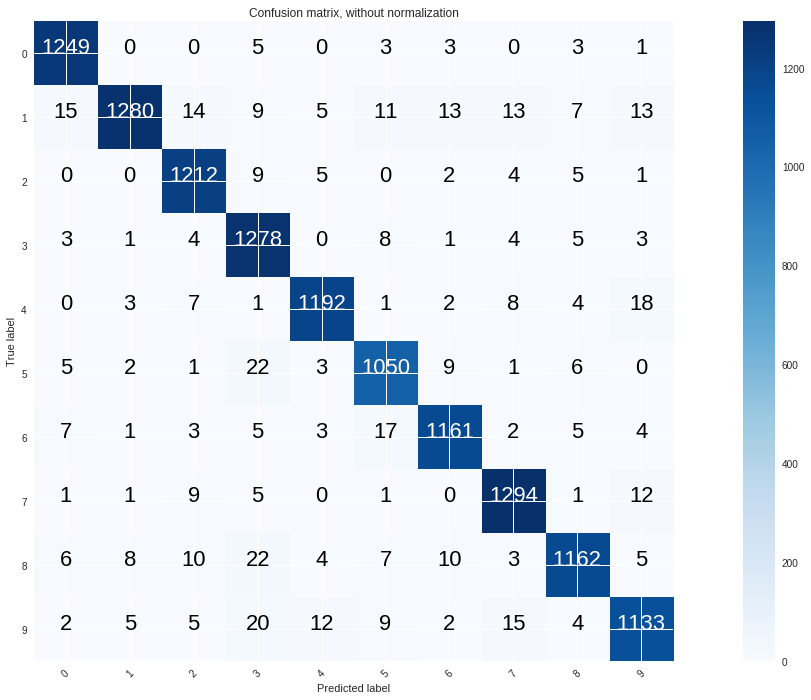

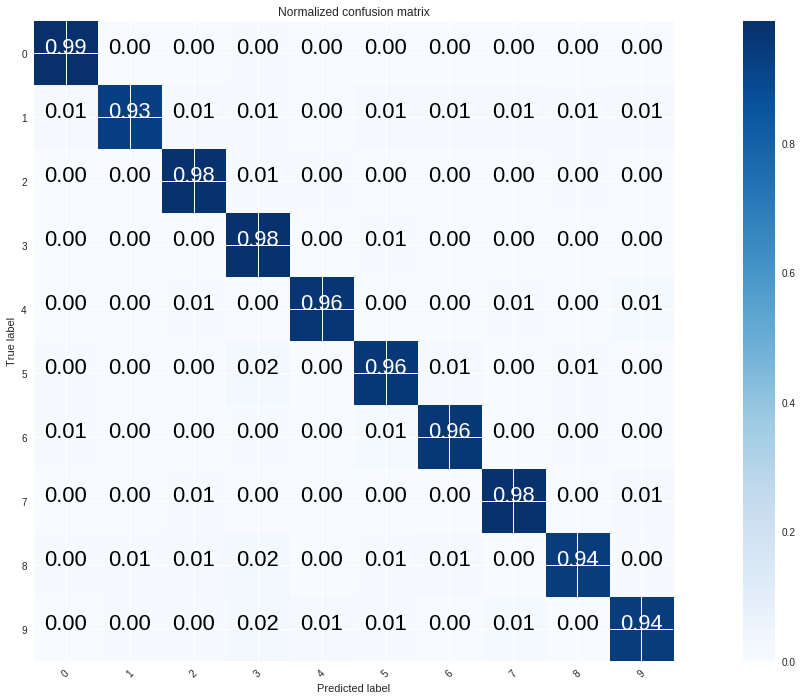

In [17]:
labels_array = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True)
img_dim = 64
num_classes = 10
input_shape = (img_dim, img_dim, 1)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_pred = model.predict_classes(x_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='CNN Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_array,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_array, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Running model 1 and 3 again on 20 epochs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
__________

45000/45000 [==============================] - 27s 593us/step - loss: 0.9054 - acc: 0.7121 - val_loss: 0.4116 - val_acc: 0.8800
Epoch 2/20
45000/45000 [==============================] - 24s 544us/step - loss: 0.4512 - acc: 0.8694 - val_loss: 0.3179 - val_acc: 0.9090
Epoch 3/20
35584/45000 [======================>.......] - ETA: 4s - loss: 0.3686 - acc: 0.8959

45000/45000 [==============================] - 24s 543us/step - loss: 0.3659 - acc: 0.8969 - val_loss: 0.2768 - val_acc: 0.9240
Epoch 4/20
45000/45000 [==============================] - 24s 544us/step - loss: 0.3205 - acc: 0.9103 - val_loss: 0.2576 - val_acc: 0.9330
Epoch 5/20
40704/45000 [==========================>...] - ETA: 2s - loss: 0.2918 - acc: 0.9179

45000/45000 [==============================] - 25s 545us/step - loss: 0.2895 - acc: 0.9185 - val_loss: 0.2548 - val_acc: 0.9374
Epoch 6/20
45000/45000 [==============================] - 25s 545us/step - loss: 0.2683 - acc: 0.9259 - val_loss: 0.2480 - val_acc: 0.9340
Epoch 7/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.2543 - acc: 0.9292

45000/45000 [==============================] - 25s 546us/step - loss: 0.2548 - acc: 0.9295 - val_loss: 0.2365 - val_acc: 0.9342
Epoch 8/20
45000/45000 [==============================] - 25s 546us/step - loss: 0.2368 - acc: 0.9337 - val_loss: 0.2334 - val_acc: 0.9384
Epoch 9/20
41984/45000 [==========================>...] - ETA: 1s - loss: 0.2256 - acc: 0.9376

45000/45000 [==============================] - 25s 545us/step - loss: 0.2247 - acc: 0.9378 - val_loss: 0.2334 - val_acc: 0.9394
Epoch 10/20
45000/45000 [==============================] - 25s 546us/step - loss: 0.2122 - acc: 0.9407 - val_loss: 0.2320 - val_acc: 0.9396
Epoch 11/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.2025 - acc: 0.9440

45000/45000 [==============================] - 25s 545us/step - loss: 0.2023 - acc: 0.9439 - val_loss: 0.2349 - val_acc: 0.9420
Epoch 12/20
45000/45000 [==============================] - 24s 544us/step - loss: 0.1906 - acc: 0.9461 - val_loss: 0.2353 - val_acc: 0.9426
Epoch 13/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1873 - acc: 0.9466

45000/45000 [==============================] - 24s 544us/step - loss: 0.1878 - acc: 0.9466 - val_loss: 0.2321 - val_acc: 0.9442
Epoch 14/20
45000/45000 [==============================] - 25s 552us/step - loss: 0.1786 - acc: 0.9489 - val_loss: 0.2301 - val_acc: 0.9430
Epoch 15/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1684 - acc: 0.9520

45000/45000 [==============================] - 25s 554us/step - loss: 0.1688 - acc: 0.9520 - val_loss: 0.2363 - val_acc: 0.9424
Epoch 16/20
45000/45000 [==============================] - 25s 546us/step - loss: 0.1643 - acc: 0.9529 - val_loss: 0.2517 - val_acc: 0.9438
Epoch 17/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1631 - acc: 0.9525

45000/45000 [==============================] - 25s 551us/step - loss: 0.1634 - acc: 0.9522 - val_loss: 0.2406 - val_acc: 0.9464
Epoch 18/20
45000/45000 [==============================] - 25s 554us/step - loss: 0.1551 - acc: 0.9545 - val_loss: 0.2478 - val_acc: 0.9444
Epoch 19/20
41728/45000 [==========================>...] - ETA: 1s - loss: 0.1527 - acc: 0.9558

45000/45000 [==============================] - 25s 551us/step - loss: 0.1528 - acc: 0.9556 - val_loss: 0.2340 - val_acc: 0.9470
Epoch 20/20
45000/45000 [==============================] - 25s 553us/step - loss: 0.1473 - acc: 0.9578 - val_loss: 0.2396 - val_acc: 0.9464
Test loss: 0.23961046066880226
Test accuracy: 0.9464


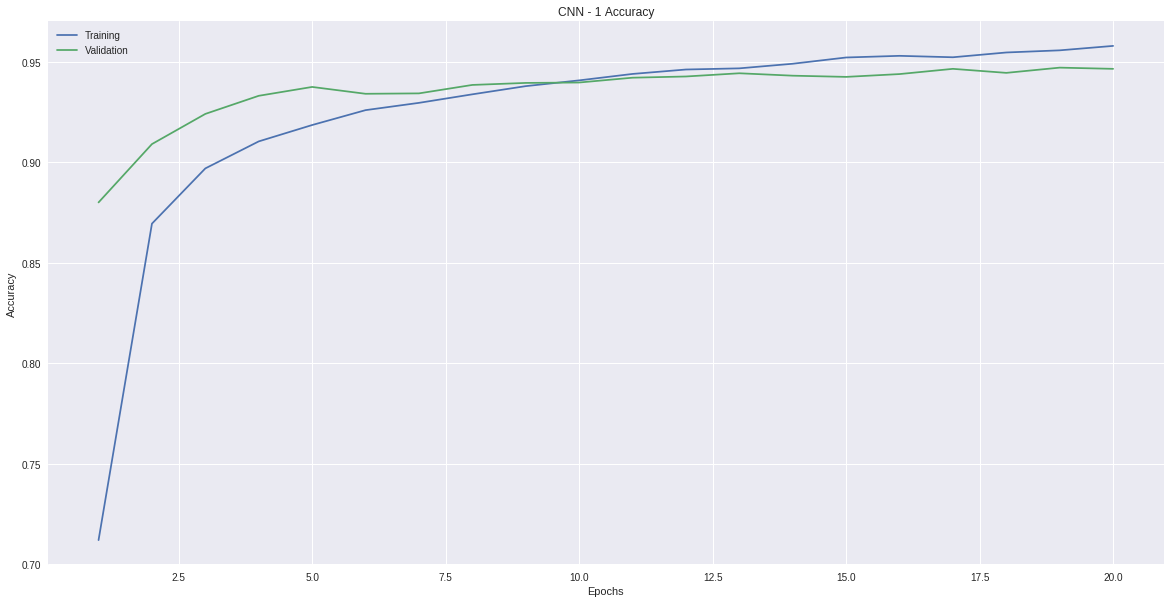

In [7]:
# CNNs
##########################################################
        

# Model 1 (Best Model):
num_classes = 10
batch_size = 256
epochs = 20

img_dim = 64

x_train, x_test, y_train, y_test = train_test_split(x, y,
    train_size=0.9, test_size=0.1, shuffle=True)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, 1)
input_shape = (img_dim, img_dim, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
BatchNormalization()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
BatchNormalization()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

history = Model_Accuracy()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam', #'adadelta'
              metrics=['accuracy'])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history.acc)
plt.plot(range(1, epochs +1), history.val_acc)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 1 Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 128)       12928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 256)         819456    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               128500    
__________

176/176 [==============================] - 34s 195ms/step - loss: 1.3769 - acc: 0.5160 - val_loss: 0.5820 - val_acc: 0.8230
Epoch 2/20
176/176 [==============================] - 33s 187ms/step - loss: 0.6424 - acc: 0.8071 - val_loss: 0.4247 - val_acc: 0.8778
Epoch 3/20
147/176 [========================>.....] - ETA: 5s - loss: 0.5153 - acc: 0.8522

176/176 [==============================] - 33s 187ms/step - loss: 0.5066 - acc: 0.8552 - val_loss: 0.3642 - val_acc: 0.9050
Epoch 4/20
176/176 [==============================] - 34s 192ms/step - loss: 0.4466 - acc: 0.8743 - val_loss: 0.3254 - val_acc: 0.9142
Epoch 5/20
167/176 [===========================>..] - ETA: 1s - loss: 0.4173 - acc: 0.8863

176/176 [==============================] - 36s 202ms/step - loss: 0.4138 - acc: 0.8871 - val_loss: 0.3167 - val_acc: 0.9150
Epoch 6/20
176/176 [==============================] - 35s 201ms/step - loss: 0.3867 - acc: 0.8920 - val_loss: 0.2948 - val_acc: 0.9204
Epoch 7/20
153/176 [=========================>....] - ETA: 4s - loss: 0.3670 - acc: 0.8990

176/176 [==============================] - 35s 196ms/step - loss: 0.3652 - acc: 0.8995 - val_loss: 0.2830 - val_acc: 0.9244
Epoch 8/20
176/176 [==============================] - 30s 172ms/step - loss: 0.3527 - acc: 0.9038 - val_loss: 0.2640 - val_acc: 0.9286
Epoch 9/20
172/176 [============================>.] - ETA: 0s - loss: 0.3322 - acc: 0.9084

176/176 [==============================] - 29s 166ms/step - loss: 0.3330 - acc: 0.9081 - val_loss: 0.2762 - val_acc: 0.9260
Epoch 10/20
176/176 [==============================] - 29s 164ms/step - loss: 0.3315 - acc: 0.9100 - val_loss: 0.2758 - val_acc: 0.9246
Epoch 11/20
175/176 [============================>.] - ETA: 0s - loss: 0.3211 - acc: 0.9124

176/176 [==============================] - 29s 167ms/step - loss: 0.3208 - acc: 0.9125 - val_loss: 0.2577 - val_acc: 0.9318
Epoch 12/20
176/176 [==============================] - 29s 164ms/step - loss: 0.3101 - acc: 0.9166 - val_loss: 0.2710 - val_acc: 0.9246
Epoch 13/20
175/176 [============================>.] - ETA: 0s - loss: 0.3061 - acc: 0.9156

176/176 [==============================] - 29s 164ms/step - loss: 0.3062 - acc: 0.9155 - val_loss: 0.2436 - val_acc: 0.9346
Epoch 14/20
176/176 [==============================] - 28s 157ms/step - loss: 0.2988 - acc: 0.9183 - val_loss: 0.2553 - val_acc: 0.9308
Epoch 15/20
174/176 [============================>.] - ETA: 0s - loss: 0.2860 - acc: 0.9222

176/176 [==============================] - 31s 177ms/step - loss: 0.2858 - acc: 0.9223 - val_loss: 0.2344 - val_acc: 0.9370
Epoch 16/20
176/176 [==============================] - 36s 202ms/step - loss: 0.2810 - acc: 0.9247 - val_loss: 0.2450 - val_acc: 0.9332
Epoch 17/20
167/176 [===========================>..] - ETA: 1s - loss: 0.2897 - acc: 0.9219

176/176 [==============================] - 33s 190ms/step - loss: 0.2883 - acc: 0.9222 - val_loss: 0.2371 - val_acc: 0.9350
Epoch 18/20
176/176 [==============================] - 34s 193ms/step - loss: 0.2737 - acc: 0.9265 - val_loss: 0.2333 - val_acc: 0.9382
Epoch 19/20
163/176 [==========================>...] - ETA: 2s - loss: 0.2709 - acc: 0.9271

176/176 [==============================] - 34s 193ms/step - loss: 0.2703 - acc: 0.9273 - val_loss: 0.2353 - val_acc: 0.9384
Epoch 20/20
176/176 [==============================] - 34s 191ms/step - loss: 0.2730 - acc: 0.9250 - val_loss: 0.2274 - val_acc: 0.9368
Test loss: 0.22740553743839265
Test accuracy: 0.9368


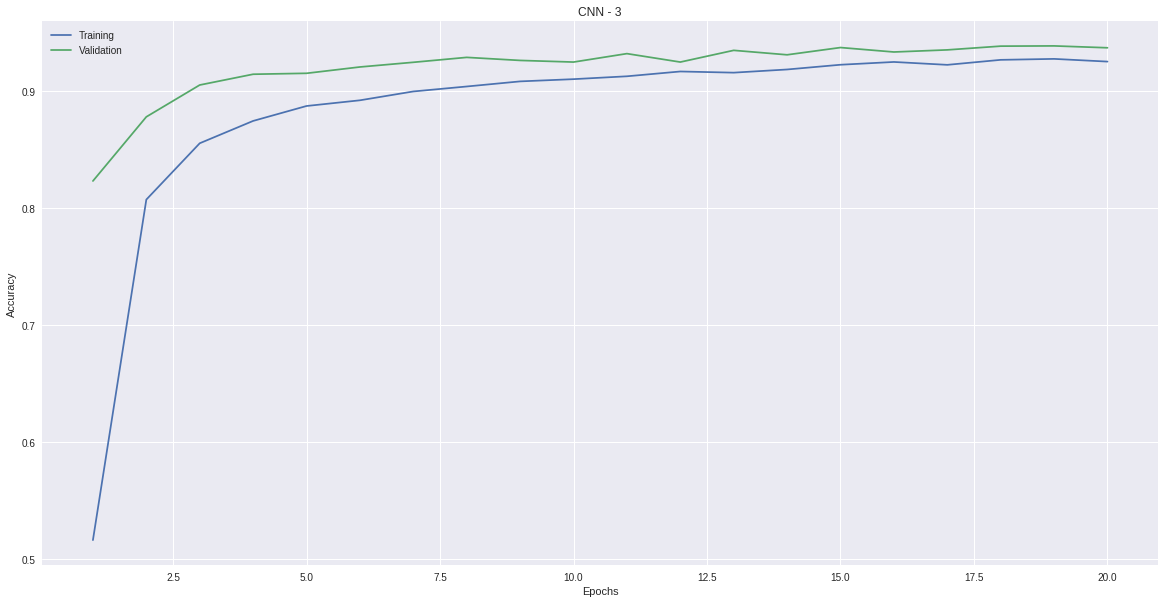

In [8]:
# Model 3

batch_size = 256

model = Sequential()
model.add(Conv2D(128, kernel_size=(10, 10), strides=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(8, 8), strides=(4, 4)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(num_classes, activation='softmax'))

history3 = Model_Accuracy()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

gen = ImageDataGenerator(rotation_range=2, width_shift_range=0.02, shear_range=0.1,
                         height_shift_range=0.02, zoom_range=0.02)

test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_gen.flow(x_test, y_test, batch_size=batch_size)

model.fit_generator(train_generator, epochs=epochs, 
                    validation_data=test_generator, verbose=1, callbacks=[history3])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history3.acc)
plt.plot(range(1, epochs +1), history3.val_acc)
plt.legend(['Training', 'Validation'])
plt.title("CNN - 3")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
# Code for producing submission.csv
##################################################
x_testers = np_x_test.reshape(-1, 64, 64) # reshape 
x_testers = np.int64(x_testers)
x_test_processed = []
for i in range(len(x_testers)):
    x_test_processed.append(preprocess(x_testers[i]))
x_test_processed = np.array(x_test_processed)
data = x_test_processed.reshape(x_test_processed.shape[0], 64, 64, 1)

data = data.astype('float32')
data /= 255
predicted_targets = model.predict_classes(data)
my_submission = pd.DataFrame({'Id': np.arange(len(predicted_targets)), 'Label': predicted_targets})
my_submission.to_csv('submission.csv', index=False)
###################################################